In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [50]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


## Define the cases

In [51]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test337"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1008/Measure_MAT/Test337_M_d60_FC72_H127_FCL0960_R00.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test337
   - testType: MPL
   - repeatType: N
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.604
   - depthAtMPL: 0.571
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod:  
   - focusingLocation: 9.6
   - remarks: Empty = Test171, GP1, GP2, GP3
=== End of Test Properties ===



In [52]:
testName2 = "Test338"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1008/Measure_MAT/Test338_M_d60_FC72_H127_FCL0960_R01.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test338
   - testType: MPL
   - repeatType: R1
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.604
   - depthAtMPL: 0.571
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod:  
   - focusingLocation: 9.6
   - remarks: Empty = Test171, GP1, GP2, GP3
=== End of Test Properties ===



## Extract Default Dataset and Set Tare

In [53]:
ds1 = loaded_mat1["DefaultData"]
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 5
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3Filtered'}
{'reference': 'MP3Filtered'}


## Shift time coord to overlap signals

In [54]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

In [55]:
ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=20, tmax=50)

# Shift ds2 time to align max of WG01
# Can change to any other probe as needed
tShift = ds2_max_idxtime['WG01'].values - ds1_max_idxtime['WG01'].values

ds2 = ds2.assign_coords(Time=ds2['Time'] - tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

Shifting ds2 by -0.5103000000000009


## Plot signals

### WM and LED Probe

In [56]:
# xmin = 0
# xmax = 50


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label=f"{testName1} WM")
# ds2['WM'].plot(linestyle='-', label=f"{testName2} WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

# fig, ax = plt.subplots(figsize=(16,9))
# ds1['LED-chan100'].plot(linestyle='-', label=f"{testName1} LED-chan100")
# ds2['LED-chan100'].plot(linestyle='-', label=f"{testName2} LED-chan100")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

### WG01

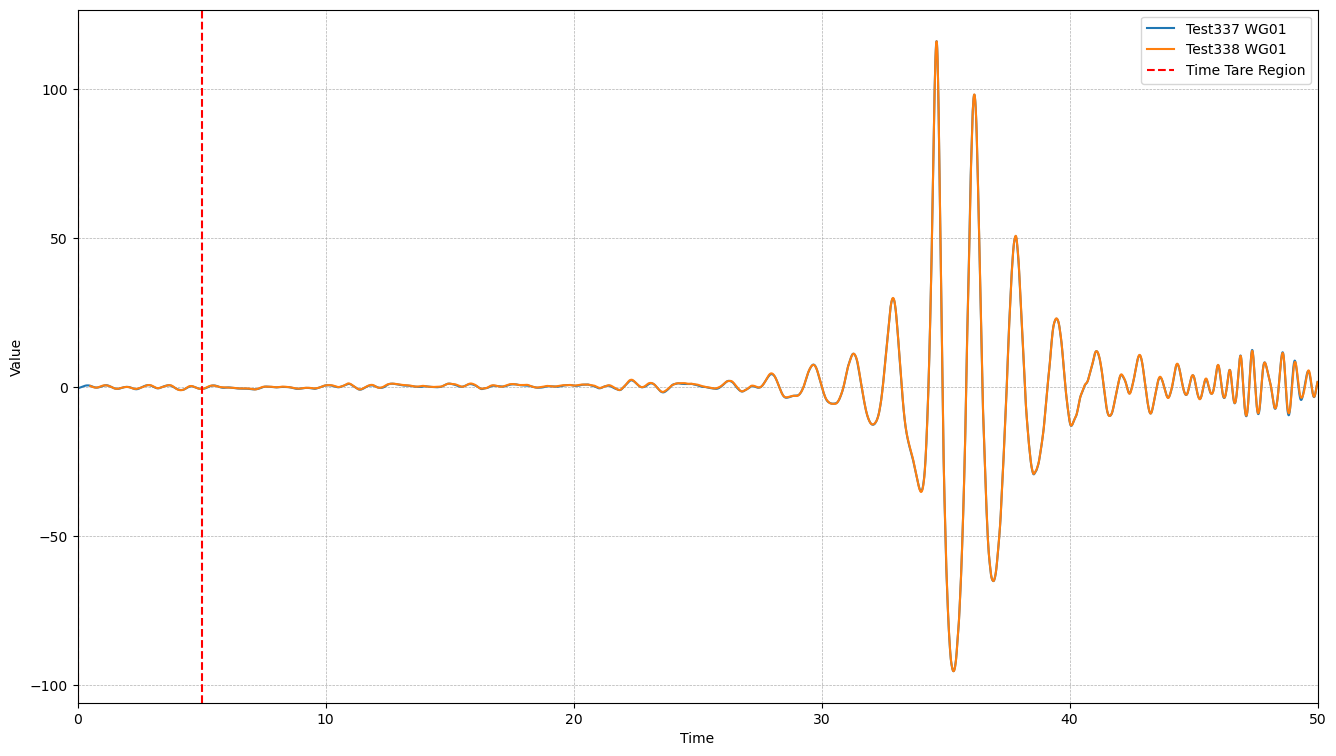

In [57]:
xmin = 0
xmax = 50

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### Mo01 - Mo02

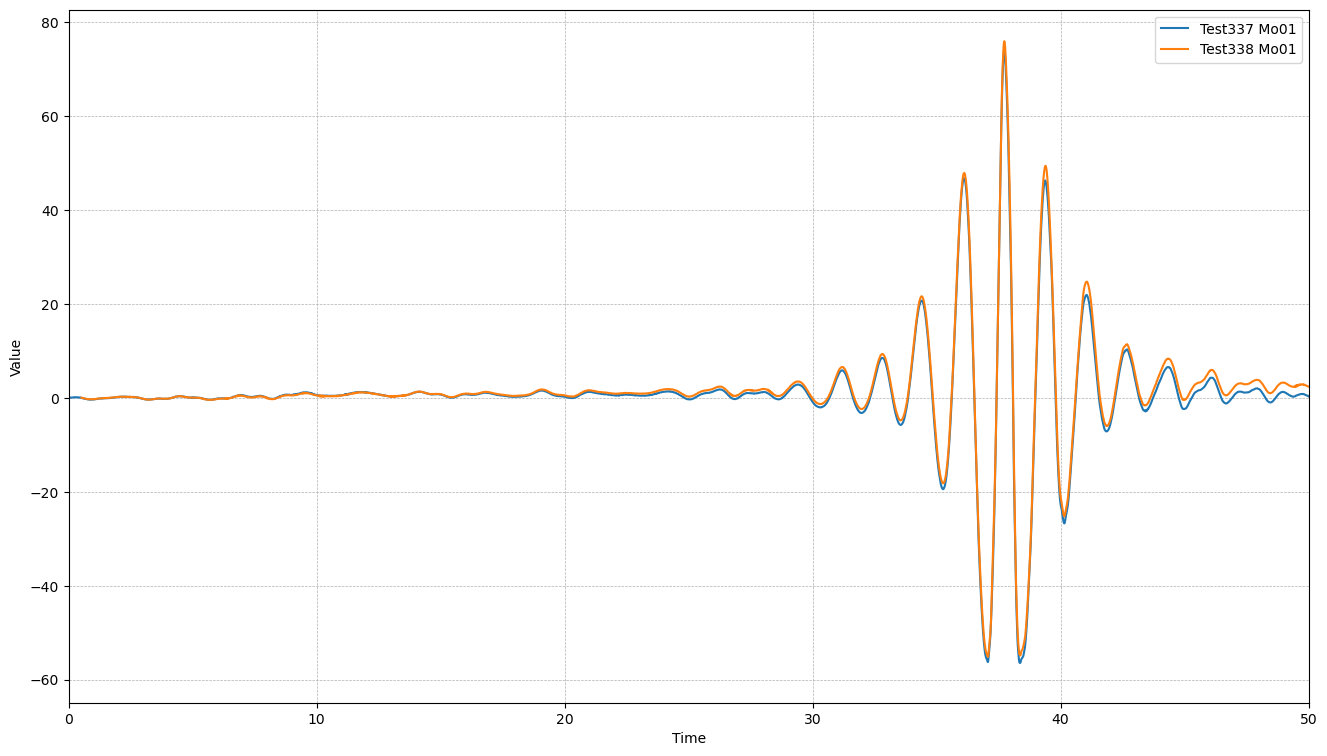

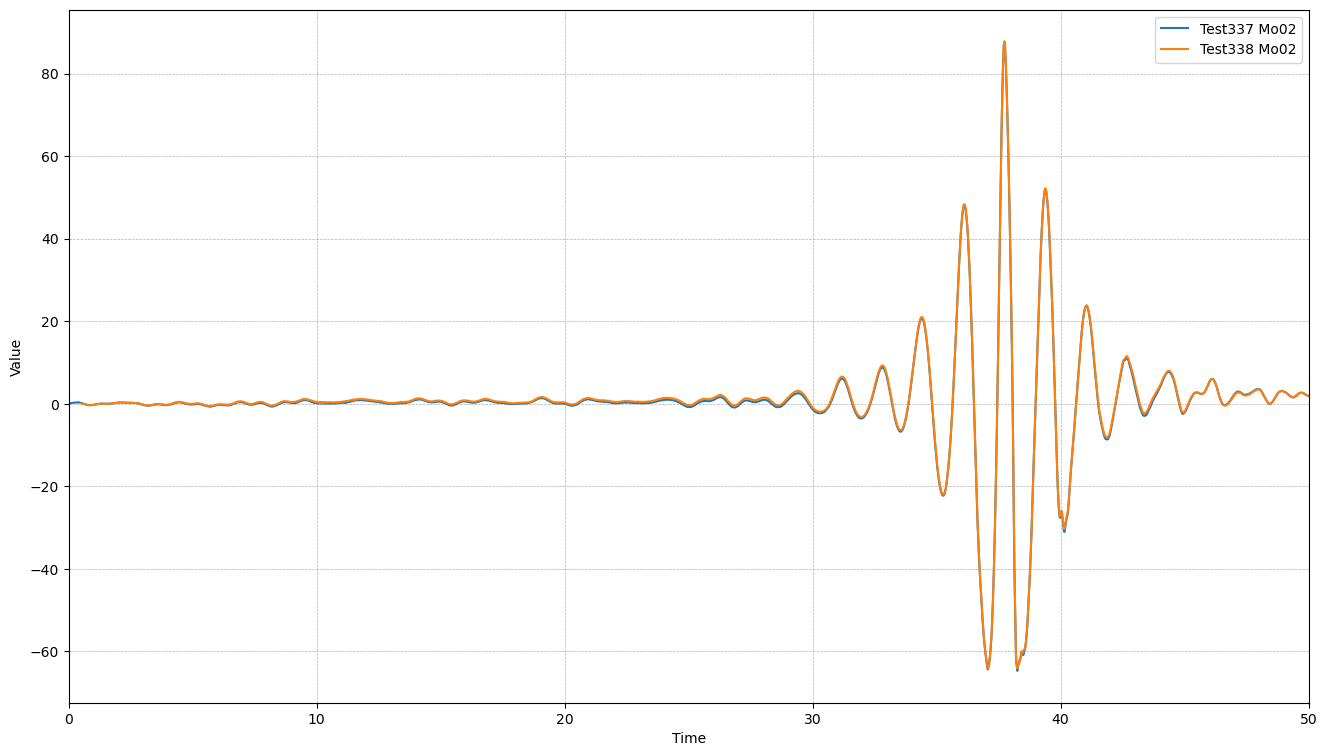

In [58]:
probeid = 'Mo01'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

probeid = 'Mo02'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### Mo03 - Mo05

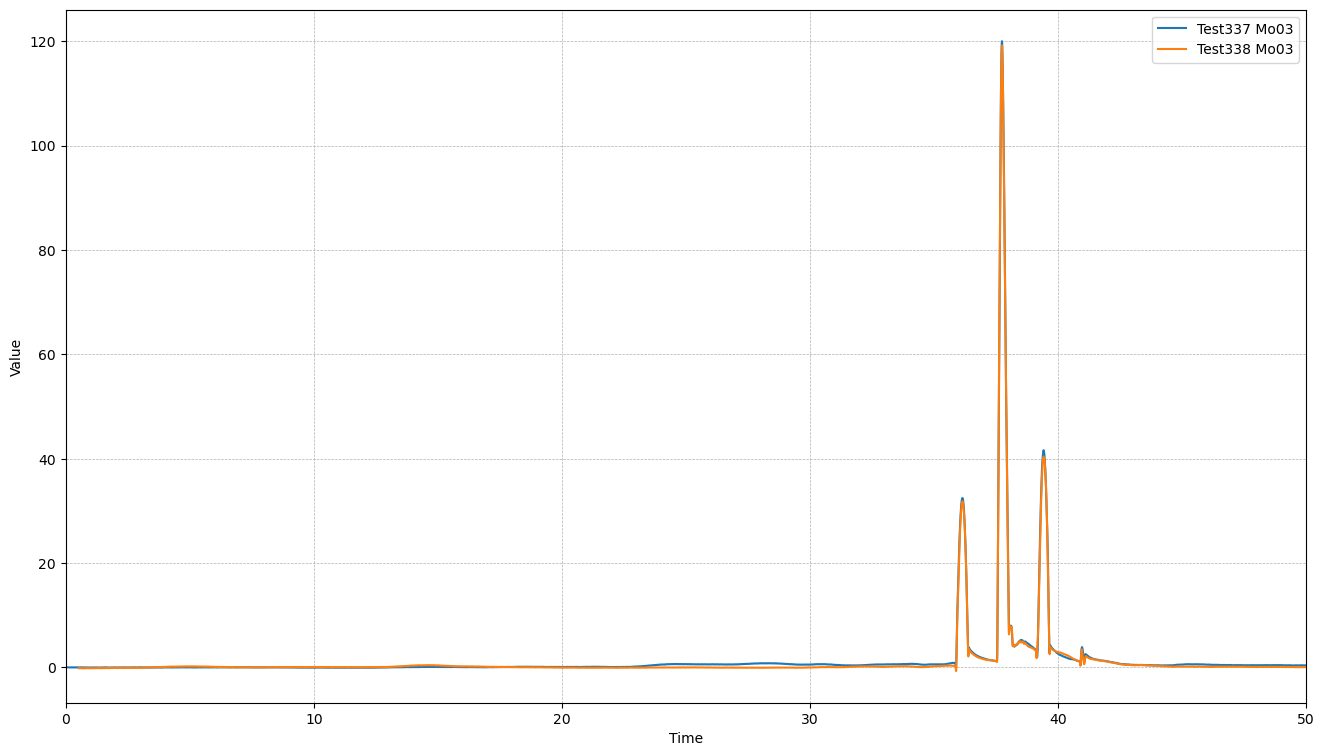

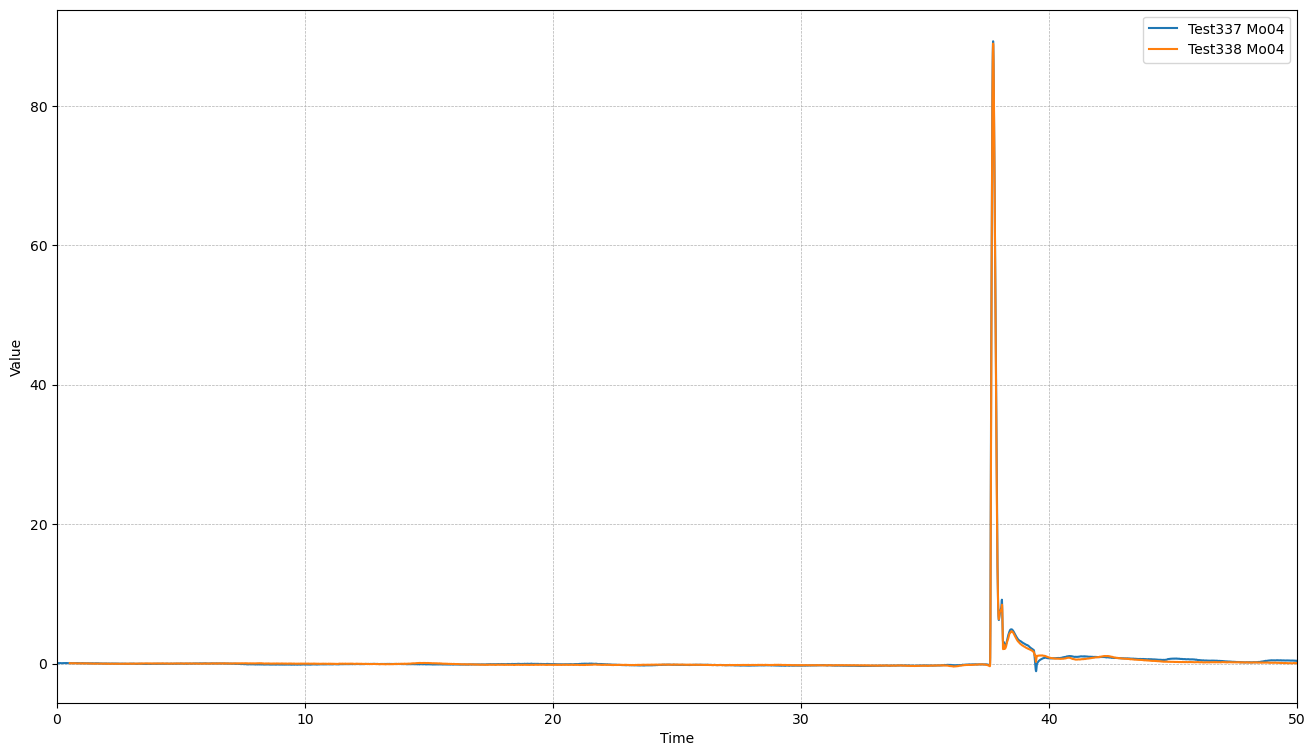

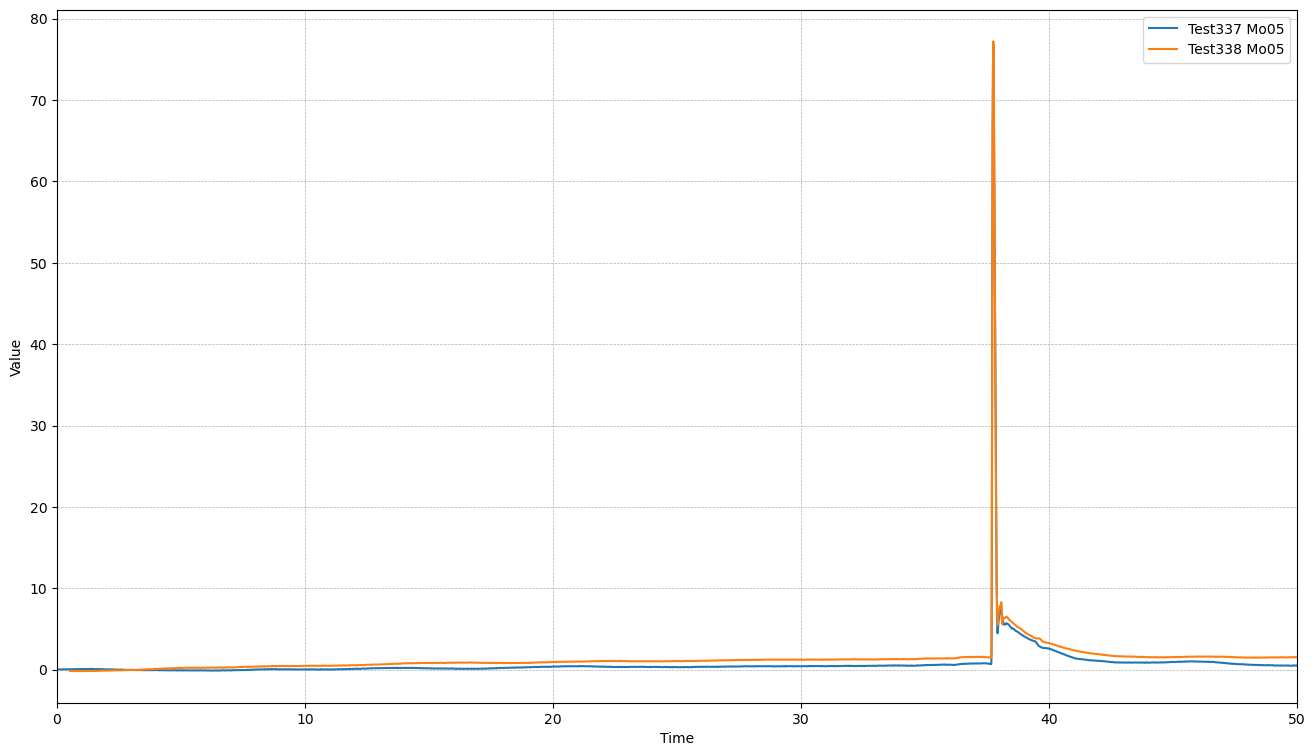

In [59]:
probeid = 'Mo03'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()


probeid = 'Mo04'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()


probeid = 'Mo05'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### Mo06 - Mo08

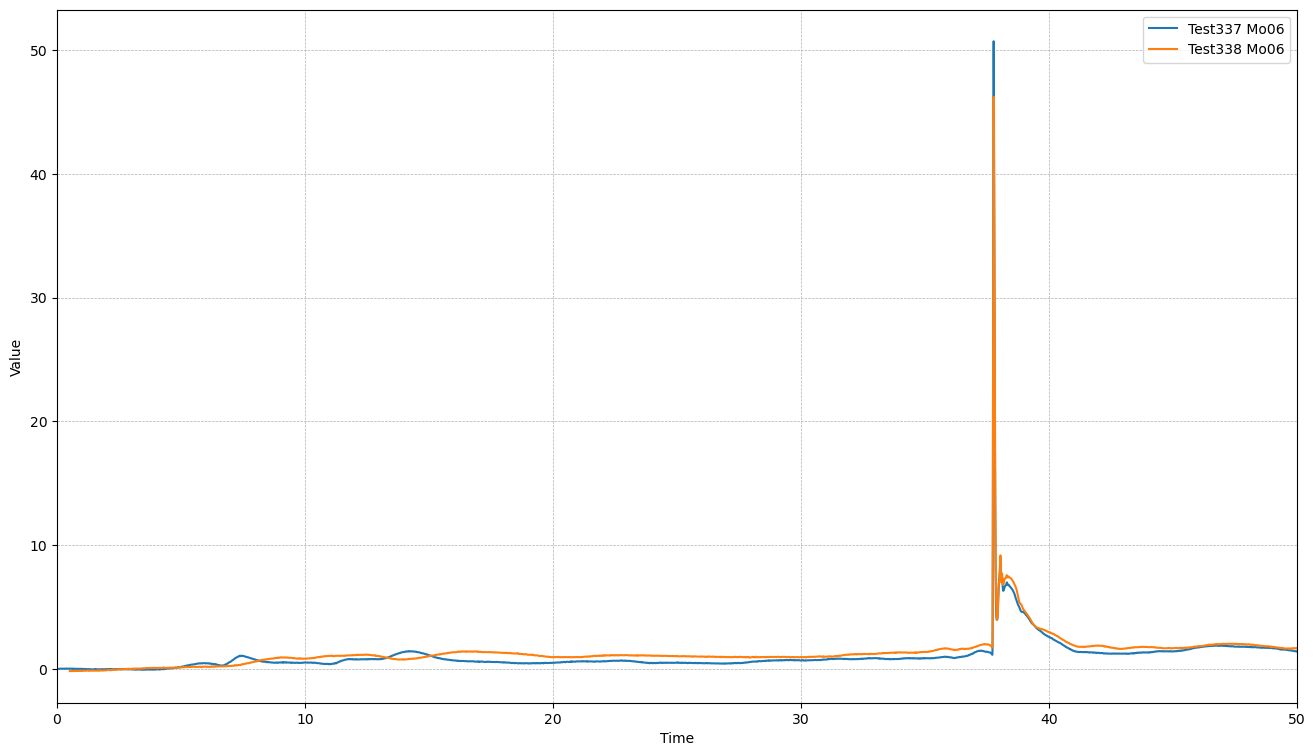

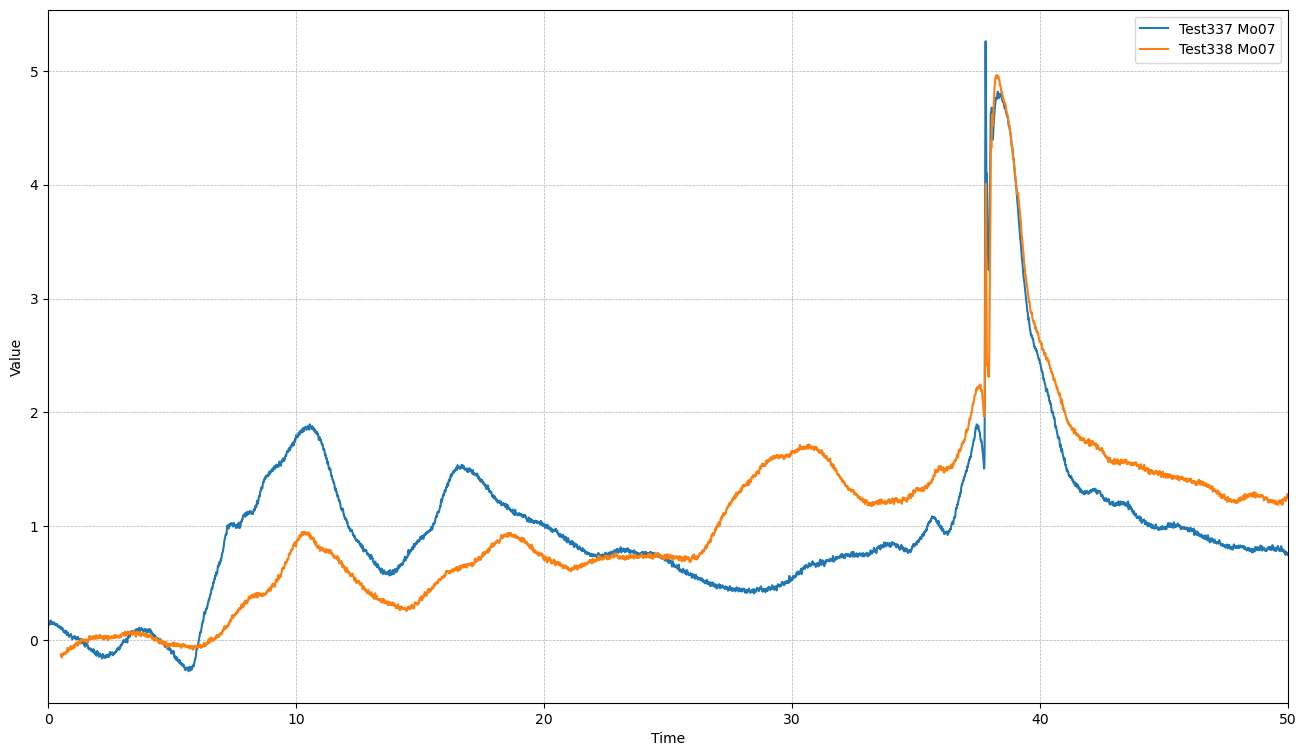

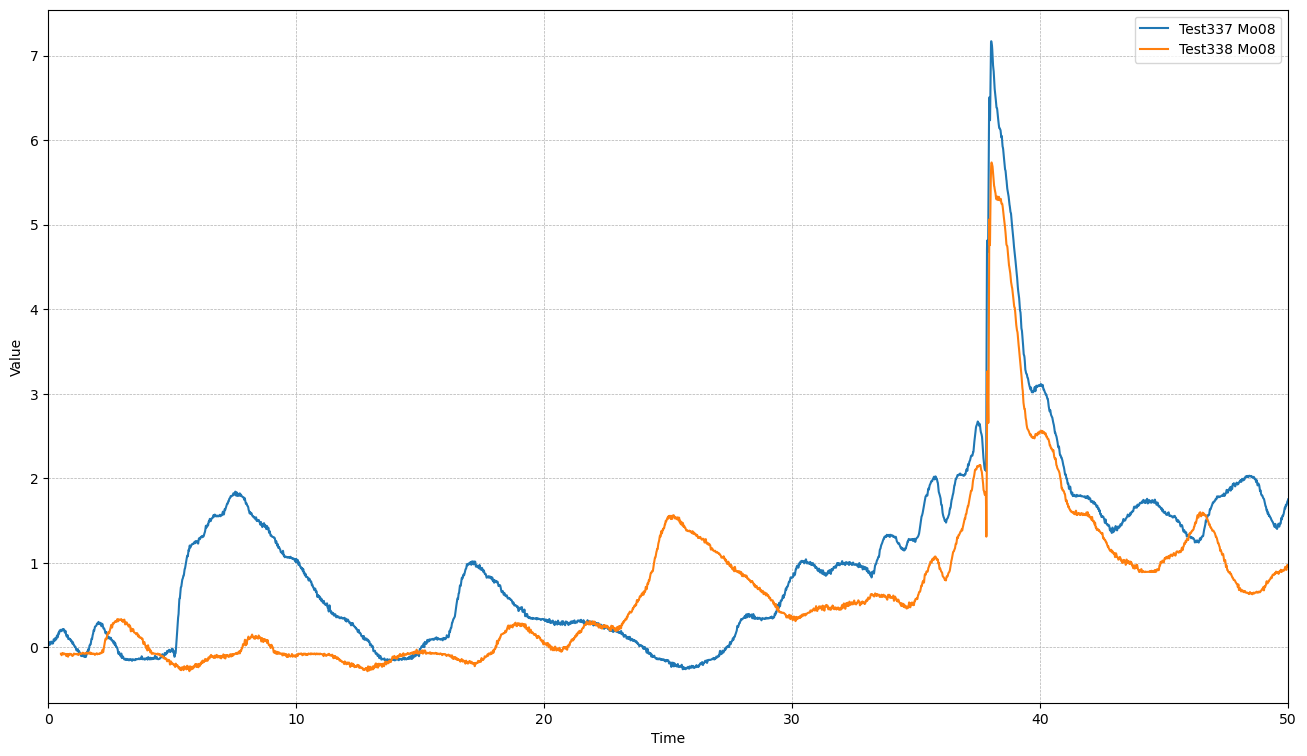

In [60]:
probeid = 'Mo06'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()


probeid = 'Mo07'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()


probeid = 'Mo08'
fig, ax = plt.subplots(figsize=(16,9))
ds1[probeid].plot(linestyle='-', label=f"{testName1} {probeid}")
ds2[probeid].plot(linestyle='-', label=f"{testName2} {probeid}")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

## Find maxima

In [61]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [62]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

probes_to_check = ['Mo01', 'Mo02', 'Mo03', 'Mo04', 'Mo05', 'Mo06', 'Mo07', 'Mo08', 'LED-chan100']

print(f"{testName1} Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut, probes=probes_to_check)
print()

print(f"{testName2} Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut, probes=probes_to_check)  

Test337 Signal Min/Max in selected time range:
Signal: Mo01   Max Value: 74.04738236731518 at :  37.7271   Min Value: -56.45841763268483 at :  38.3599
Signal: Mo02   Max Value: 87.64611250122182 at :  37.7300   Min Value: -64.71048749877818 at :  38.2534
Signal: Mo03   Max Value: 120.01611178770386 at :  37.7437   Min Value: -0.07858821229613966 at :  35.8901
Signal: Mo04   Max Value: 89.26509201153397 at :  37.7446   Min Value: -1.099977988466037 at :  39.4771
Signal: Mo05   Max Value: 76.65974100283425 at :  37.7529   Min Value: -0.11785899716574733 at :  6.2188
Signal: Mo06   Max Value: 50.71305688515294 at :  37.7671   Min Value: -0.06647511484705859 at :  3.1738
Signal: Mo07   Max Value: 5.259695191086131 at :  37.8003   Min Value: -0.27340480891386676 at :  5.6577
Signal: Mo08   Max Value: 7.17124693578355 at :  38.0259   Min Value: -0.2609530642164444 at :  25.5908
Signal: LED-chan100   Max Value: 1.0 at :  7.1260   Min Value: 0.0 at :  0.0049

Test338 Signal Min/Max in selected

## Plot Spec

In [63]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 102390
Least count Hz = 0.020001953315753492
Max Freq (Half band) Hz = 1024.0
Sample Len = 102390
Least count Hz = 0.020001953315753492
Max Freq (Half band) Hz = 1024.0
Sample Len = 102390
Least count Hz = 0.020001953315753492
Max Freq (Half band) Hz = 1024.0
Sample Len = 101346
Least count Hz = 0.020208000315750006
Max Freq (Half band) Hz = 1024.0


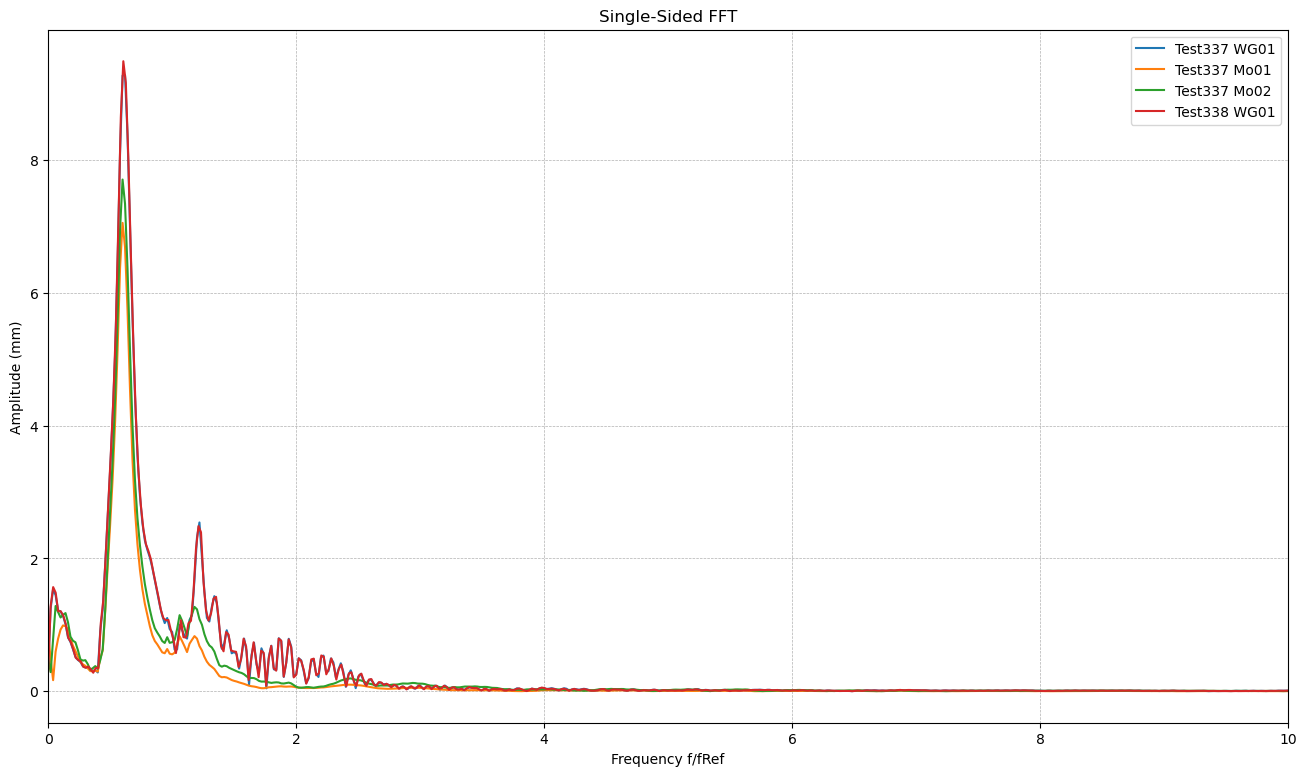

In [64]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

fSampling1 = loaded_mat1['TestProperties']['fSampling']
fSampling2 = loaded_mat2['TestProperties']['fSampling']

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, f"{testName1} WG01")
getSpec(ds1_cut['Mo01'], fSampling1, ax, xlim, f"{testName1} Mo01")
getSpec(ds1_cut['Mo02'], fSampling1, ax, xlim, f"{testName1} Mo02")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, f"{testName1} WG07")

getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, f"{testName2} WG01")

pass